In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import fsolve
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def calc_price(theta1, theta2, cost, wtp):
    """compute each insurer's price (assumes interior solution)"""
    p1 = (2*theta1+theta2)/3. + cost
    p2 = (2*theta2+theta1)/3. + cost
    return p1, p2
  
    
def calc_t(theta1, theta2, cost, wtp):
    """compute the proportion of people choosing each insurer
    assumes interior solution"""
    p1, p2 = calc_price(theta1, theta2, cost, wtp)
    t_hat = .5 + (p2 - p1)/(2.*cost)
    return t_hat


def calc_profits(theta1,theta2,cost, wtp):
    t= calc_t(theta1, theta2, cost, wtp)
    p1,p2 = calc_price(theta1, theta2, cost, wtp)
    profits1, profits2 = t*(p1-theta1), (1-t)*(p2-theta2)
    hosp_profit = t*theta1 +  (1-t)*theta2
    return hosp_profit, profits1, profits2

    
def outside_simlt(theta1, theta2, cost, wtp):
    """outside option in simult case
    assuming listprice high enough"""
    r  = 0 #.25
    t_hat = calc_t(theta1, theta2, cost, wtp)
    #t_hat = .5
    #print(theta1, theta2,  t_hat)
    return r*t_hat*theta2 + (1-t_hat)*theta2

#arbitrary outside option...
def nash_in_nash(theta1, theta2, cost, wtp,beta=.5):
    hosp_profit, profits1, profits2 = calc_profits(theta1, theta2,  cost,  wtp)
    obj = -1*(np.log(max(hosp_profit-outside_simlt(theta1, theta2,cost, wtp),1e-4))*(1-beta) 
              + np.log(profits1)*beta)
    return obj


COST = 5
WTP = 25

print(nash_in_nash(COST,COST, COST, WTP))

-0.9162907318741551


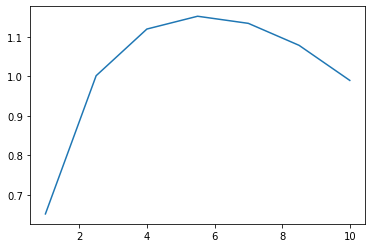

In [3]:
COST = 5
WTP = 25

plt.plot([i for i in np.linspace(1,2*COST,num=7)], 
         [-1*nash_in_nash(i, 7.5, COST,WTP) for i in np.linspace(1,2*COST,num=7)])

In [4]:
def bargain_helper(theta1, theta2, cost, wtp,beta=.5):
    """solve each firm 1s optimization holding theta 2 fixed"""
    result = minimize(nash_in_nash, theta1, args=(theta2,cost, wtp, beta),
                      method='Nelder-Mead', options={'disp': False})
    return result.x

COST = 5
WTP  = 25
print(bargain_helper(7.5,7.5, COST,WTP))

[5.625]


In [5]:
def simult_bargain(theta1, theta2, cost, wtp, betas=[.5,.5]):
    """solve the bargaining problems seperately and iterate for a solution"""       
    
    #loop variables
    diff =  theta1

    maxiter = 10
    while maxiter >=0 and diff > 10e-7:
        #seems as though there is a contraction mapping here, need to think more about why
        theta1 = bargain_helper(theta1, theta2, cost, wtp, betas[0])
        theta2 = bargain_helper(theta2, theta1, cost, wtp, betas[1])
        
        #update loop variables
        diff = np.abs(np.max(theta1 - theta2))
        maxiter = maxiter-1
        
    return theta1, theta2

COST = 5
WTP  = 25
print(simult_bargain(11.25,11.25,COST,WTP))

(array([4.99998594]), array([4.99998462]))


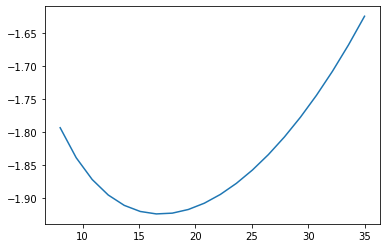

In [6]:
def bargain_helper_seq(theta1, cost, wtp,beta=.5):
    """ solve firm 1s optimization holding theta 2 fixed """
    result = minimize( nash_in_nash, 10., args=(theta1, cost, wtp,beta),
                      method='Nelder-Mead', options={'disp': False} )
    return result.x


def seq_obj(theta1, cost, wtp,betas=[.5,.5]):
    """ theta1 is a guess for the first stage """
    
    theta2 = bargain_helper_seq(theta1, cost, wtp, betas[1])
    
    return nash_in_nash(theta1, theta2, cost, wtp,betas[0])


COST = 5
WTP = 25
plt.plot([i for i in np.linspace(COST+3,WTP +10,num=20)],  
         [seq_obj(i, 13.5 , WTP) for i in np.linspace(COST+3,WTP +10,num=20)])


In [7]:
def seq_bargain(theta1, cost, wtp,betas=[.5,.5]):
    """solve the bargaining problems seperately,
    then solve for the solution"""   
    #only compute no deal 1x for initial
    result = minimize(seq_obj, theta1, args=(cost, wtp,betas),
                      method='Nelder-Mead', options={'disp': False})
    
    theta1 = result.x
    theta2 = bargain_helper(theta1, theta1, cost, wtp,beta=betas[1])
    return theta1, theta2



(array([6.24597168]), array([5.31151576]))


TypeError: calc_profits() missing 2 required positional arguments: 'cost' and 'wtp'

In [8]:
def make_table(arg, steps, params,betas=[.5,.5]):
    """the argument is 
    args =  0 -cost, 1 - wtp
    steps = min_arg, max_arg, no_step """
    
    min_arg, max_arg, no_step = steps
    
    cols = ['eq_type','listprice','distance_cost','mc1','mc2','profit1','profit2','hosp_profit','share1','share2']
    
    indep_var = np.linspace(min_arg, max_arg, no_step)
    
    for eq_type in ['Simultaneous', 'Sequential']:
        result1 = []
        result2 = []
        for var in indep_var:
        
            param_copy = list(params)
            param_copy[arg] = var
            cost,wtp = param_copy
            
            mc1,mc2 = 20,20
            
            if eq_type == 'Simultaneous':
                mc1,mc2 = simult_bargain(mc1, mc2, cost, wtp,betas=betas)
            else:
                mc1,mc2 = seq_bargain(mc1, cost, wtp,betas=betas)
            
            s1 = calc_t(mc1,mc2, cost,wtp)
            s2 = calc_t(mc2,mc1,cost,wtp)
            p1,p2 = calc_price(mc1,mc2,cost,wtp)
            pi1,pi2 = s1*(p1-mc1),  s2*(p2-mc2)
            pi_h = s1*mc1 + s2*mc2
            cons1 = wtp - s1*cost - p1
            cons2 = wtp - s2*cost - p2
            
            result1.append( (cost, mc1, p1, pi1,  pi_h) ) 
            result2.append( (cost, mc2, p2, pi2,  pi_h) ) 
        print('\n',eq_type, '\n')
        
        for line in result1:
            print("%.3f & %.3f  & %.3f  & %.3f  & %.3f  \\\\"%line)
            
        print('\n')
        
        for line in result2:
            print("%.3f & %.3f  & %.3f  & %.3f  & %.3f   \\\\"%line)
            
make_table(0, (5,7,3), (5,25),betas=[.5,.5])


 Simultaneous 

5.000 & 5.000  & 10.000  & 2.500  & 5.000  \\
6.000 & 6.000  & 12.000  & 3.000  & 6.000  \\
7.000 & 7.000  & 14.000  & 3.500  & 7.000  \\


5.000 & 5.000  & 10.000  & 2.500  & 5.000   \\
6.000 & 6.000  & 12.000  & 3.000  & 6.000   \\
7.000 & 7.000  & 14.000  & 3.500  & 7.000   \\

 Sequential 

5.000 & 6.250  & 10.938  & 2.197  & 5.752  \\
6.000 & 7.500  & 13.125  & 2.637  & 6.902  \\
7.000 & 8.750  & 15.313  & 3.076  & 8.053  \\


5.000 & 5.313  & 10.625  & 2.822  & 5.752   \\
6.000 & 6.375  & 12.750  & 3.387  & 6.902   \\
7.000 & 7.438  & 14.875  & 3.951  & 8.053   \\
